In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

file_path = "styles.csv"
data = pd.read_csv(file_path, on_bad_lines='skip')
data.head()

data = data.drop(columns=['Unnamed: 10', 'Unnamed: 11'], errors='ignore')
critical_columns = ['year', 'masterCategory', 'baseColour', 'season', 'gender', 'usage']
data = data.dropna(subset=critical_columns)
data['year'] = data['year'].astype(int)

filtered_data = data[(data['year'] >= 2011) & (data['year'] <= 2012)]
min_samples = 5
filtered_data = filtered_data[filtered_data['masterCategory'].map(filtered_data['masterCategory'].value_counts()) >= min_samples]
print("Filtered data shape:", filtered_data.shape)



Filtered data shape: (29922, 10)


In [5]:
categorical_columns = ['baseColour', 'season', 'gender', 'usage']

column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ],
    remainder='passthrough'
)

#Define features and target
X_master = filtered_data[['baseColour', 'season', 'gender', 'year', 'usage']]
y_master = filtered_data['masterCategory']

# Train-test split
X_train_master, X_test_master, y_train_master, y_test_master = train_test_split(
    X_master, y_master, test_size=0.2, random_state=42
)

print(f"Train size: {X_train_master.shape[0]}, Test size: {X_test_master.shape[0]}")


Train size: 23937, Test size: 5985


In [7]:
#Build pipeline
pipeline_master = Pipeline(steps=[
    ('preprocessor', column_transformer),
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'))
])

# Hyperparameter tuning
param_grid_master = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
grid_search_master = GridSearchCV(
    pipeline_master, param_grid_master, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1
)
grid_search_master.fit(X_train_master, y_train_master)

print("Best parameters found:", grid_search_master.best_params_)

pipeline_master = grid_search_master.best_estimator_

# Evaluation
y_pred_master = pipeline_master.predict(X_test_master)
accuracy = accuracy_score(y_test_master, y_pred_master)
print(f"Test Accuracy: {accuracy:.4f}")


Fitting 2 folds for each of 36 candidates, totalling 72 fits


C:\Users\meros\AppData\Roaming\Python\Python312\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['baseColour',
                                                                          'season',
                                                                          'gender',
                                                                          'usage'])])),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_estimators=200,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__min_samples_leaf': [1, 2],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=1)

Best parameters found: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Test Accuracy: 0.6092


Text(0.5, 1.0, 'Confusion Matrix for masterCategory')

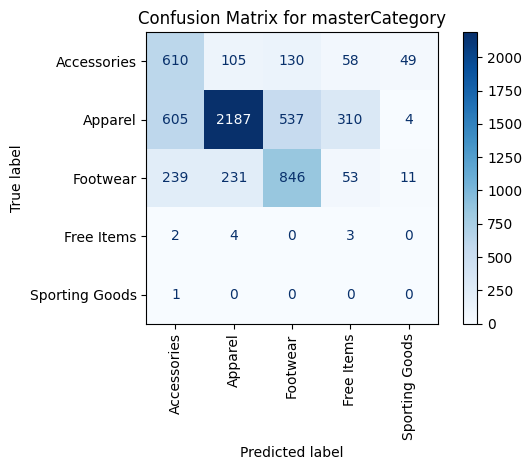

In [6]:
# Confusion Matrix
labels_master = np.unique(np.concatenate((y_test_master, y_pred_master)))
conf_matrix = confusion_matrix(y_test_master, y_pred_master, labels=labels_master)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=labels_master)
disp.plot(cmap='Blues', xticks_rotation='vertical')

plt.title("Confusion Matrix for masterCategory")
plt.tight_layout()
plt.show()

## balancing data set more oversmaple small classes or undersample large ones



In [11]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train_master_resampled, y_train_master_resampled = ros.fit_resample(X_train_master, y_train_master)

print("Class distribution after oversampling:")
print(pd.Series(y_train_master_resampled).value_counts())


Class distribution after oversampling:
masterCategory
Apparel           14549
Accessories       14549
Footwear          14549
Free Items        14549
Sporting Goods    14549
Name: count, dtype: int64


C:\Users\meros\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
C:\Users\meros\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [13]:
pipeline_master_balanced = Pipeline(steps=[
    ('preprocessor', column_transformer),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

pipeline_master_balanced.fit(X_train_master_resampled, y_train_master_resampled)

y_pred_master_balanced = pipeline_master_balanced.predict(X_test_master)
balanced_accuracy = accuracy_score(y_test_master, y_pred_master_balanced)
print(f"Accuracy on Test Data after oversampling: {balanced_accuracy:.4f}")


C:\Users\meros\AppData\Roaming\Python\Python312\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['baseColour', 'season',
                                                   'gender', 'usage'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

Accuracy on Test Data after oversampling: 0.6050


Text(0.5, 1.0, 'Confusion Matrix for masterCategory (Oversampled)')

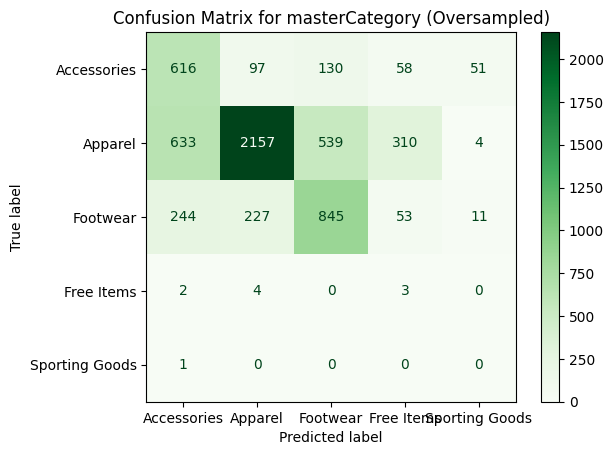

In [15]:
# Confusion matrix for the oversampled model
labels_master_balanced = np.unique(np.concatenate((y_test_master, y_pred_master_balanced)))
conf_matrix_balanced = confusion_matrix(y_test_master, y_pred_master_balanced, labels=labels_master_balanced)
disp_balanced = ConfusionMatrixDisplay(conf_matrix_balanced, display_labels=labels_master_balanced)
disp_balanced.plot(cmap='Greens')
plt.title("Confusion Matrix for masterCategory (Oversampled)")
plt.show()


## Hyper parameter tuning


In [9]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#Split the data (train-test split before oversampling)
X_master = filtered_data[['baseColour', 'season', 'gender', 'year', 'usage']]
y_master = filtered_data['masterCategory']

X_train_master, X_test_master, y_train_master, y_test_master = train_test_split(
    X_master, y_master, test_size=0.2, random_state=42, stratify=y_master
)


In [11]:
#Define a pipeline and hyperparameter grid for grid search
pipeline_master = Pipeline(steps=[
    ('preprocessor', column_transformer),  # Preprocess raw input data
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

param_grid_master = {
    'classifier__n_estimators': [100, 200],  
    'classifier__max_depth': [None, 10, 20],  
    'classifier__min_samples_split': [5, 10], 
    'classifier__min_samples_leaf': [1, 2]  
}

#Perform GridSearchCV using the original (non-resampled) dataset
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Increased folds to 5
grid_search_master = GridSearchCV(
    pipeline_master, param_grid_master, cv=cv, scoring='accuracy', n_jobs=2, verbose=2  
)

In [13]:
grid_search_master.fit(X_train_master, y_train_master)

# Print best parameters
print("Best Parameters:", grid_search_master.best_params_)

# Step 5: Evaluate the best model on the test data
best_model = grid_search_master.best_estimator_
y_pred_master = best_model.predict(X_test_master)
test_accuracy = accuracy_score(y_test_master, y_pred_master)
print(f"Test Accuracy: {test_accuracy:.4f}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits


C:\Users\meros\AppData\Roaming\Python\Python312\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['baseColour',
                                                                          'season',
                                                                          'gender',
                                                                          'usage'])])),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=2,
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__min_samples_leaf': [1, 2],
                         'classifier__min_samples_split': [5, 10],
                         'classifier__n_estimators': [100, 200]},
             scoring='accuracy', verbose=2)

Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Test Accuracy: 0.6175


Text(0.5, 1.0, 'Confusion Matrix for masterCategory')

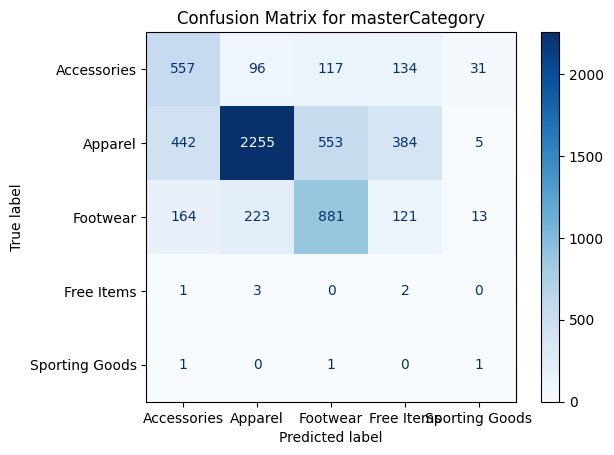

In [15]:
# Plot confusion matrix
labels_master = np.unique(np.concatenate((y_test_master, y_pred_master)))
conf_matrix_master = confusion_matrix(y_test_master, y_pred_master, labels=labels_master)
disp_master = ConfusionMatrixDisplay(conf_matrix_master, display_labels=labels_master)
disp_master.plot(cmap='Blues')

plt.title("Confusion Matrix for masterCategory")
plt.show()

# Baysian

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestClassifier

X_master_encoded = pd.get_dummies(X_master)

X_train, X_test, y_train, y_test = train_test_split(X_master_encoded, y_master, test_size=0.2, random_state=42)

param_space = {
    'n_estimators': (50, 500),  
    'max_depth': (1, 20),  
    'min_samples_split': (2, 20),  
    'min_samples_leaf': (1, 20),  
}

# set up the Bayesian Optimization
opt = BayesSearchCV(
    RandomForestClassifier(),
    param_space,
    n_iter=50, 
    cv=5,  
    n_jobs=-1,  
    random_state=42
)

# Fit the model with the training data
opt.fit(X_train, y_train)

# Get the best hyperparameters and the corresponding model
best_params = opt.best_params_
best_model = opt.best_estimator_

# Evaluate the model on the test data
test_accuracy = best_model.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")
print("Best Hyperparameters:", best_params)


BayesSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
              random_state=42,
              search_spaces={'max_depth': (1, 20), 'min_samples_leaf': (1, 20),
                             'min_samples_split': (2, 20),
                             'n_estimators': (50, 500)})

Test Accuracy: 0.7337
Best Hyperparameters: OrderedDict({'max_depth': 19, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500})


<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Confusion Matrix')

Text(0.5, 36.72222222222221, 'Predicted Labels')

Text(70.72222222222221, 0.5, 'True Labels')

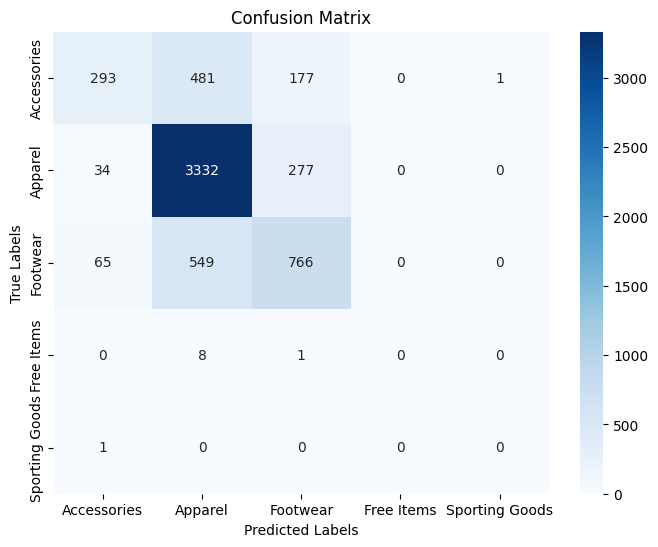

In [26]:
y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


# Grid search results 

<Figure size 800x600 with 0 Axes>

<Axes: xlabel='param_classifier__max_depth', ylabel='param_classifier__n_estimators'>

Text(0.5, 1.0, 'Grid Search: Accuracy vs. n_estimators and max_depth')

Text(0.5, 36.72222222222221, 'max_depth')

Text(70.72222222222221, 0.5, 'n_estimators')

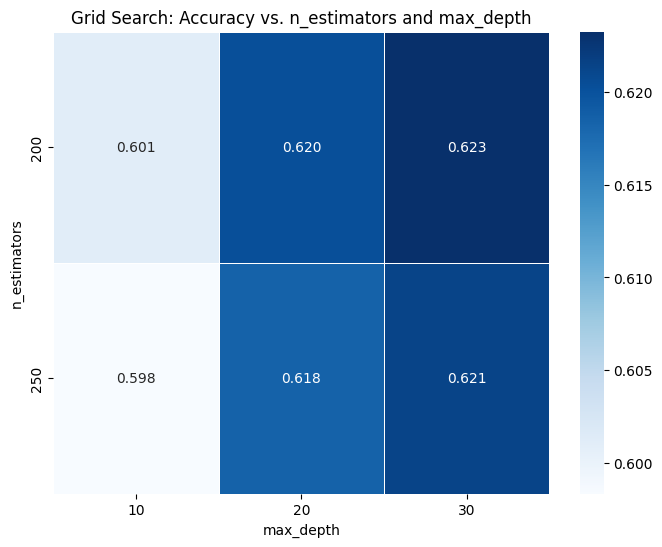

In [33]:
# Extract the results from the grid search
results = grid_search_master.cv_results_

results_df = pd.DataFrame(results)
results_df = results_df.groupby(['param_classifier__n_estimators', 'param_classifier__max_depth'], as_index=False).agg({'mean_test_score': 'mean'})

# Now you can create the pivot table
heatmap_data = results_df.pivot(index='param_classifier__n_estimators', 
                                columns='param_classifier__max_depth', 
                                values='mean_test_score')

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt='.3f', linewidths=0.5)
plt.title('Grid Search: Accuracy vs. n_estimators and max_depth')
plt.xlabel('max_depth')
plt.ylabel('n_estimators')
plt.show()


<Figure size 800x600 with 0 Axes>

<Axes: xlabel='param_max_depth', ylabel='param_n_estimators'>

Text(0.5, 1.0, 'Bayesian Optimization: Accuracy vs. n_estimators and max_depth')

Text(0.5, 36.72222222222221, 'max_depth')

Text(70.72222222222221, 0.5, 'n_estimators')

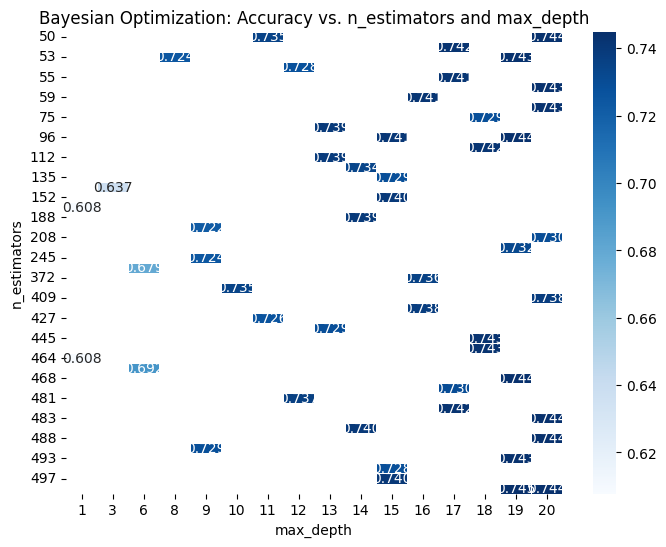

In [37]:
results_bayes = opt.cv_results_
results_bayes_df = pd.DataFrame(results_bayes)
heatmap_data_bayes = results_bayes_df.pivot(index='param_n_estimators', columns='param_max_depth', values='mean_test_score')

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data_bayes, annot=True, cmap='Blues', fmt='.3f', linewidths=0.5)
plt.title('Bayesian Optimization: Accuracy vs. n_estimators and max_depth')
plt.xlabel('max_depth')
plt.ylabel('n_estimators')
plt.show()


# ORAGNAIZED CODE MORE FROM SCRATCH

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import optuna
import random
from collections import Counter

file_path = "styles.csv"
raw = pd.read_csv(file_path, on_bad_lines='skip')

for col in ['Unnamed: 10', 'Unnamed: 11']:
    if col in raw.columns:
        raw.drop(columns=[col], inplace=True)

critical = ['year','masterCategory','baseColour','season','gender','usage']
raw.dropna(subset=critical, inplace=True)

raw['year'] = raw['year'].astype(int)
raw = raw[(raw['year'] >= 2011) & (raw['year'] <= 2012)]

# Keep only frequent classes
counts = raw['masterCategory'].value_counts()
valid = counts[counts >= 5].index
data = raw[raw['masterCategory'].isin(valid)].reset_index(drop=True)

Filtered data shape: (29922, 10)


In [7]:
## Feature Engineering

categorical_columns = ['baseColour', 'season', 'gender', 'usage']

# Separate features and target
X_master = filtered_data[['baseColour', 'season', 'gender', 'year', 'usage']]
y_master = filtered_data['masterCategory']

# One-Hot Encoding for categorical features
X_master_encoded = pd.get_dummies(X_master)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_master_encoded, y_master, test_size=0.2, random_state=42)

print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")


Train size: 23937, Test size: 5985


In [11]:
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

print(f"Resampled Train size: {X_train_resampled.shape[0]}")

C:\Users\meros\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
C:\Users\meros\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Resampled Train size: 72745


In [13]:
param_space = {
    'n_estimators': (50, 500),
    'max_depth': (1, 20),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 20),
}

opt = BayesSearchCV(
    RandomForestClassifier(random_state=42),
    param_space,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    random_state=42
)

opt.fit(X_train_resampled, y_train_resampled)

best_model = opt.best_estimator_
best_params = opt.best_params_

print("Best Hyperparameters:", best_params)

Best Hyperparameters: OrderedDict({'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500})


In [ ]:
test_accuracy = best_model.score(X_test, y_test)
print(f"Test Accuracy after oversampling: {test_accuracy:.4f}")

y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title('Confusion Matrix after Oversampling')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()